# GARCH 广义自回归条件异方差模型

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arch #GARCH所用到的库
import statsmodels as sm
import warnings
import datetime #用于时间转换
warnings.filterwarnings("ignore")

In [43]:
data=pd.read_excel('/Users/singal/Desktop/工作/第二次工作/案例一：股指期货案例/数据/表2数据.xlsx')

In [44]:
data.head()

,Unnamed: 0,沪深300指数现货收盘价,沪深300指数期货收盘价
0,2009-04-16,2687.11,NaN
1,2009-04-17,2650.69,NaN
2,2009-04-20,2707.67,NaN
3,2009-04-21,2675.44,NaN
4,2009-04-22,2576.28,NaN


In [45]:
data=data.rename(columns={'Unnamed: 0':'日期'})#更改列名

In [46]:
data['对数价格']=np.log(data['沪深300指数现货收盘价'])
data['对数收益率']=data['对数价格']-data['对数价格'].shift(1)
data=data.drop('沪深300指数期货收盘价',axis=1)#本案例不需要期货数据

In [47]:
y=data['对数收益率'].dropna()#第一行没有数据，故删去。

In [48]:
data.head()

,日期,沪深300指数现货收盘价,对数价格,对数收益率
0,2009-04-16,2687.11,7.896222,NaN
1,2009-04-17,2650.69,7.882575,-0.013646
2,2009-04-20,2707.67,7.903844,0.021269
3,2009-04-21,2675.44,7.891869,-0.011975
4,2009-04-22,2576.28,7.854102,-0.037767


在介绍GARCH之前，先引入ARCH自回归条件异方差模型，ARCH的具体构建步骤如下：
1. 检验时间序列的平稳性，可用ADF检验。
2. 绘制偏相关系数图，以得到均值方程，如m阶的AR模型。
3. 构建AR模型，得到残差，并生成残差平方。
4. 检验残差平方的相关性，检测方法可以为混成检验（Ljung-Box test）等，若存在相关性，则GARCH或ARCH效应存在；并确定残差平方的自相关阶数。
5. 以方差作为被解释变量，残差作为解释变量构建AR模型。

经过上述步骤即可得到ARCH(m)模型：
$$ a_t=sigma_t \epsilon_t$$
$$\sigma_t^2=\alpha_0+\sum_{i=1}^m \alpha_i a_{t-i}^2$$

对原案例作补充：混成检验，又称LB检验，是根据一系列滞后阶数来判断序列是否存在相关性。
$$\begin{aligned}
&H_0:\qquad\hat\rho_1^2=\hat\rho_2^2=\cdots=\hat\rho_k^2=0\\
&\\
&H_1:\qquad \hat\rho_k^2 \not=0,\quad 1\leq k\leq h\\
&\\
&Q=n(n+2)\sum_{k=1}^h \frac{\hat\rho_k^2}{n-k}\sim X(h)\\
\end{aligned}$$

In [49]:
adf=sm.api.tsa.stattools.adfuller(data['对数价格'])#检验平稳性

sm.tsa.stattools.adfuller函数返回值依次为：
1. 统计量的值
2. 伴随概率
3. 阶数
4. 样本个数
5. 3种显著性水平及对应的置信区间

In [50]:
adf#无法拒绝原假设，对数价格序列是非平稳的

(-2.3739455291571887,
 0.14922550984098537,
 0,
 485,
 {'1%': -3.443905150512834,
  '5%': -2.867517732199813,
  '10%': -2.569953900520778},
 -2480.089452553145)

绘制偏相关系数图，确定自回归阶数。

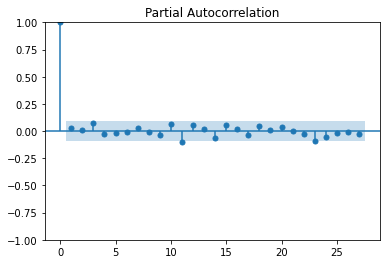

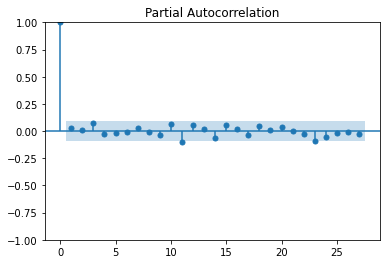

In [51]:
sm.api.graphics.tsa.plot_pacf(y)#十一阶自相关系数显著不为0，故建立AR(11)模型

构建AR(11)模型，作为均值方程。

In [52]:
model = sm.tsa.arima.model.ARIMA(y,order=(11,0,0)).fit()#均值方程

Text(0.5, 1.0, 'Residuals Squares')

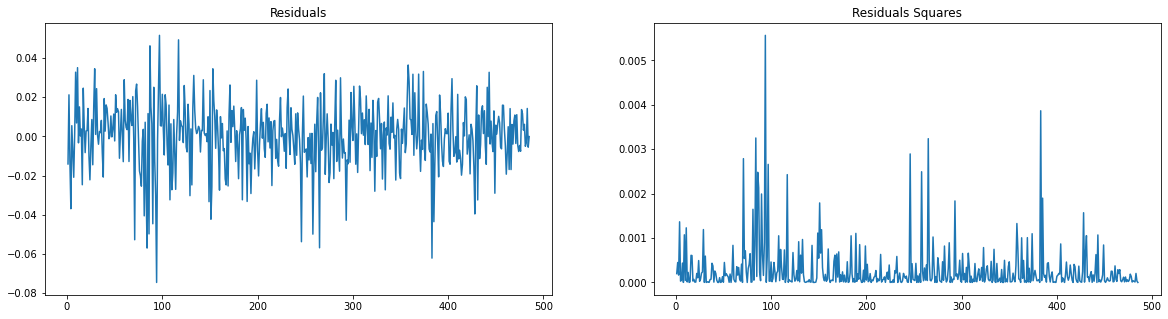

In [53]:
a=y-model.fittedvalues#得到残差
a2=a**2#生成残差平方项

fig=plt.figure(figsize=(20,5))
ax1=fig.add_subplot(121)
ax1.plot(a)
ax1.set_title('Residuals')

ax2=fig.add_subplot(122)
ax2.plot(a2)
ax2.set_title('Residuals Squares')

观察可得，对数收益率的残差大致不存在相关性，但是残差的平方存在相关性，即存在GARCH效应，下面对残差平方进行混成检验，以得到显著结论。

In [54]:
test=sm.tsa.stattools.acf(a2,nlags=20,qstat=True)#返回值依次为自相关系数，混成检验统计量，伴随概率
test

(array([ 1.00000000e+00,  1.33204103e-02,  9.99207620e-02,  1.65006872e-01,
         5.82346498e-02,  6.50969938e-04,  9.26627944e-02,  1.53437064e-01,
         2.80107863e-02,  3.56551078e-02,  1.54913017e-01,  4.02175085e-02,
         4.51039438e-02,  1.49925222e-01,  2.66898584e-02, -1.33290922e-02,
         6.72842566e-02,  2.44933449e-02, -4.31556427e-03,  2.77584801e-02,
         9.96190695e-02]),
 array([ 0.08658856,  4.96900753, 18.31121607, 19.97650103, 19.97670955,
        24.21066196, 35.84397357, 36.23248421, 36.86330682, 48.79639677,
        49.60237383, 50.61824491, 61.86631731, 62.22354271, 62.31282679,
        64.59277391, 64.89554963, 64.90496915, 65.29551871, 70.33635634]),
 array([7.68559733e-01, 8.33669138e-02, 3.79395549e-04, 5.04761787e-04,
        1.26236971e-03, 4.77648986e-04, 7.75760752e-06, 1.59201233e-05,
        2.78381757e-05, 4.43851493e-07, 7.37836752e-07, 1.08762561e-06,
        2.43032767e-08, 4.76243393e-08, 1.00524139e-07, 8.65531248e-08,
        1.6

In [55]:
acf,q,p=test
df=pd.DataFrame()
df['AC']=acf[1:]#自相关系数多出一项，即lag=0，故需删除
df['Q-statistic']=q
df['p-value']=p
df['lag']=range(1,21)
df=df.set_index('lag')
df

,AC,Q-statistic,p-value
lag,,,
1,0.013320,0.086589,7.685597e-01
2,0.099921,4.969008,8.336691e-02
3,0.165007,18.311216,3.793955e-04
4,0.058235,19.976501,5.047618e-04
5,0.000651,19.976710,1.262370e-03
6,0.092663,24.210662,4.776490e-04
7,0.153437,35.843974,7.757608e-06
8,0.028011,36.232484,1.592012e-05
9,0.035655,36.863307,2.783818e-05


一阶自相关系数所对应的Q统计量的伴随概率小于0.1，其他阶的自相关系数所对应的Q统计量的伴随概率均小于0.01，故拒绝原假设，认为残差平方存在相关性，即存在GARCH效应。下面建立ARCH模型。

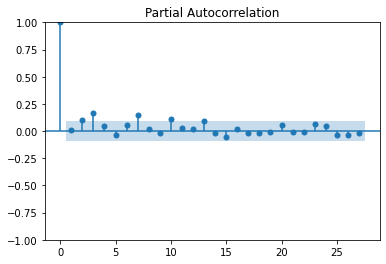

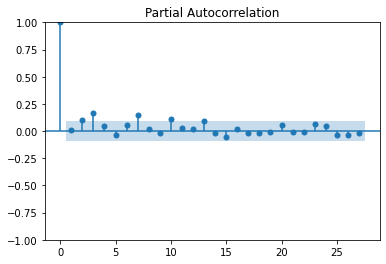

In [56]:
sm.api.graphics.tsa.plot_pacf(a2)#大致定位10阶，建立AR(10)模型

接下来即可根据残差的10阶滞后项建立关于方差的AR(10)模型，所得模型即为ARCH模型。实际中可以直接使用arch库，方便快捷。

arch.arch_model函数的主要参数：
1. y，表示时间序列。
2. x，传入外生变量。
3. mean，指定均值函数的类型，如“Constant”、“AR”等。
4. lags，指定均值函数的滞后项。
5. vol，指定波动率模型的类型，如“ARCH”、”GARCH“等。
6. p，波动率模型的滞后阶数。

In [57]:
import arch

model=arch.arch_model(y,mean='AR',lags=11,vol='ARCH',p=10)
result=model.fit(disp='off')#display=off，表示输出一个较为简洁的结果
print(result.summary())

                           AR - ARCH Model Results                            
Dep. Variable:                  对数收益率   R-squared:                       0.016
Mean Model:                        AR   Adj. R-squared:                 -0.007
Vol Model:                       ARCH   Log-Likelihood:                1280.90
Distribution:                  Normal   AIC:                          -2515.80
Method:            Maximum Likelihood   BIC:                          -2420.10
                                        No. Observations:                  474
Date:                Tue, Oct 26 2021   Df Residuals:                      451
Time:                        11:25:30   Df Model:                           23
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      8.7200e-04  1.234e-03      0.706      0.480 

In [58]:
model=arch.arch_model(y,mean='AR',lags=11,vol='GARCH').fit(disp='off')
print(model.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                  对数收益率   R-squared:                       0.022
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                1274.50
Distribution:                  Normal   AIC:                          -2519.01
Method:            Maximum Likelihood   BIC:                          -2456.59
                                        No. Observations:                  474
Date:                Tue, Oct 26 2021   Df Residuals:                      459
Time:                        11:25:32   Df Model:                           15
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      4.6466e-04  7.619e-04      0.610      0.542 

表格最下方汇报了波动率模型的两个参数 $\alpha$ 和 $\beta$ 且均在1%的置信水平下显著。故得到波动率模型：$$\sigma_t^2=0.00003+0.05 a_{t-1}^2+0.85 \sigma_{t-1}^2$$
最后参照教学案例，在GARCH模型中引入哑变量 $D_t$，股指期货推出(2010-4-16)前后分别为0和1。则原模型改进为：
$$\sigma_t^2=\omega+\alpha a_{t-1}^2+\beta \sigma_{t-1}^2+\gamma D_t$$ 
若哑变量的系数$\gamma$显著为正，则股指期货的推出加剧了股票市场的波动，若为显著为负，则减缓了股票市场的波动，若显著为0，则股指期货的推出对现货市场的影响甚微。

In [59]:
data=data.set_index('日期')
data['股指期货推出前后']=1
data.loc[:'2010-4-16','股指期货推出前后']=0
data['股指期货推出前后'].value_counts()

0    246
1    240
Name: 股指期货推出前后, dtype: int64

In [64]:
model=arch.arch_model(y,x=np.array(data['股指期货推出前后']),mean='AR',lags=11,vol='GARCH',p=1,q=1).fit(disp='off')
print(model.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                  对数收益率   R-squared:                       0.022
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                1274.50
Distribution:                  Normal   AIC:                          -2519.01
Method:            Maximum Likelihood   BIC:                          -2456.59
                                        No. Observations:                  474
Date:                Tue, Oct 26 2021   Df Residuals:                      459
Time:                        11:27:33   Df Model:                           15
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      4.6466e-04  7.619e-04      0.610      0.542 

引入虚拟变量后的估计结果和未引入虚拟变量的估计结果一致。